In [ ]:
!unzip lemmatized.zip

In [1]:
import math
import os

import torch
from torchtext.vocab import build_vocab_from_iterator
from torch import nn, Tensor
from tempfile import TemporaryDirectory
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from typing import Tuple

from sklearn.neighbors import kneighbors_graph
from tqdm.notebook import tqdm, trange
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class Dataset():
    def __iter__(self):
        for genre in ['ballads', 'elegies', 'songs', 'novels']:
            for file in os.listdir('../datasets/lemmatized/' + genre):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    yield f.read().split()

In [4]:
def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    data = [torch.tensor(vocab(item), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

In [5]:
def batchify(data: Tensor, bsz: int) -> Tensor:
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
sentences = Dataset()
vocab = build_vocab_from_iterator(sentences)

In [ ]:
data = data_process(sentences)
data = batchify(data, bsz=20)

In [8]:
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [5]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of ``-inf``, with zeros on ``diag``."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [7]:
bptt = 35 #
ntokens = len(vocab)  # size of vocabulary
emsize = 128  # embedding dimension
d_hid = 128  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [ ]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 0.0005  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model, train_data) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(trange(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

In [ ]:
best_val_loss = float('inf')
epochs = 1

In [ ]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, data)
    scheduler.step()

  0%|          | 0/42600 [00:00<?, ?it/s]

| epoch   1 |   200/42599 batches | lr 0.00 | ms/batch 41.97 | loss  8.90 | ppl  7337.13
| epoch   1 |   400/42599 batches | lr 0.00 | ms/batch 41.86 | loss  7.80 | ppl  2428.73
| epoch   1 |   600/42599 batches | lr 0.00 | ms/batch 41.11 | loss  7.59 | ppl  1975.68
| epoch   1 |   800/42599 batches | lr 0.00 | ms/batch 41.27 | loss  7.40 | ppl  1638.12
| epoch   1 |  1000/42599 batches | lr 0.00 | ms/batch 41.85 | loss  7.50 | ppl  1806.09
| epoch   1 |  1200/42599 batches | lr 0.00 | ms/batch 41.89 | loss  7.37 | ppl  1594.24
| epoch   1 |  1400/42599 batches | lr 0.00 | ms/batch 41.27 | loss  7.30 | ppl  1481.53
| epoch   1 |  1600/42599 batches | lr 0.00 | ms/batch 42.06 | loss  7.27 | ppl  1442.66
| epoch   1 |  1800/42599 batches | lr 0.00 | ms/batch 41.97 | loss  7.17 | ppl  1303.95
| epoch   1 |  2000/42599 batches | lr 0.00 | ms/batch 41.64 | loss  7.17 | ppl  1300.74
| epoch   1 |  2200/42599 batches | lr 0.00 | ms/batch 41.92 | loss  7.19 | ppl  1326.52
| epoch   1 |  2400/4

In [ ]:
torch.save(model.state_dict(), 'transformer_weights')

In [8]:
model.load_state_dict(torch.load('transformer_weights.zip', map_location=device))
model.eval()
model.to('cpu')

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (encoder): Embedding(339687, 128)
  (decoder): Linear(in_features=128, out_features=339687, bias=True)
)

In [14]:
def getvec(sentence):
    model.eval();
    model.to('cpu')
    with torch.no_grad():    
        src = torch.tensor(vocab(sentence), dtype=torch.long)[:, None]
        src = model.encoder(src) * math.sqrt(model.d_model)
        src = model.pos_encoder(src)
        src_mask = generate_square_subsequent_mask(bptt).to(device)
        output = model.transformer_encoder(src, src_mask)
    return output[:, 0, :]

In [9]:
import os
import gensim
from gensim import utils
from tqdm.notebook import tqdm
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means, SpectralClustering, KMeans
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

In [10]:
class Dataloader:
    def __iter__(self):
        for genre in ['ballads', 'elegies', 'songs', 'novels']:
            for file in os.listdir('../datasets/lemmatized/' + genre):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    fname = '../datasets/lemmatized/' + genre + '/' + file
                    if genre == 'novels':
                        author = file.split('.')[0]
                    elif genre == 'ballads':
                        author = file.split('_')[2]
                    else:
                        author = file.split('_')[1]
                    yield utils.simple_preprocess(f.read()), genre, author, fname
sentences = Dataloader()

fnames = []
texts = []
true_labels = []
authors = []

for (sent, genre, author, fname) in sentences:
    if not sent:
        continue
    texts. append(sent)
    true_labels.append(genre)
    authors.append(author)
    fnames.append(fname)

In [11]:
def getprob(sentence):
    model.eval()
    model.to('cpu')
    with torch.no_grad():    
        src = torch.tensor(vocab(sentence), dtype=torch.long)[:, None]
        src_mask = generate_square_subsequent_mask(bptt).to(device)
        output = model(src, src_mask)
    return output

In [12]:
total_words = []
for t in texts:
    for w in t:
        total_words.append(w)

In [13]:
not_in_vocab = [x for x in set(total_words) if x not in vocab]
print(len(not_in_vocab), not_in_vocab)

207 ['чорез', 'потуда', 'жжжза', 'недружки', 'наплаво', 'meлитина', 'трески', 'содми', 'апопз', 'высоковысоко', 'исподнее', 'жжжверно', 'ррровно', 'отомански', 'ideeе', 'немирнсй', 'мыслимо', 'vиritи', 'всамотко', 'азиатик', 'почетнее', 'вовенарг', 'божеско', 'печерочку', 'жоффрен', 'присмотря', 'болярсково', 'сохраниши', 'бриссак', 'онучински', 'доступно', 'фебовы', 'жжжхоть', 'обоснованному', 'машалах', 'свежехонько', 'натко', 'вупсалу', 'жжжслепота', 'неспособно', 'вонми', 'искупующе', 'ёчге', 'пребожественно', 'дисленьше', 'полинял', 'откуде', 'одновремнно', 'полях', 'гужно', 'уголинно', 'пилося', 'изъянно', 'тощой', 'пррравильно', 'циво', 'vпосле', 'стоящю', 'рассто', 'irеnе', 'избранного', 'кончно', 'miloце', 'преметко', 'costumи', 'алёшеньке', 'косметически', 'непрменно', 'слюбен', 'mурин', 'sociиtи', 'обязы', 'паефши', 'ницево', 'пыльно', 'неулежно', 'санечку', 'агде', 'неспопутно', 'ринально', 'дрехи', 'croisи', 'случаем', 'kaрасев', 'какаяжь', 'безрасцветно', 'сотъа', 'действ

In [14]:
texts_ = []
for text in texts:
    text_clean = []
    for w in text:
        if w not in not_in_vocab:
            text_clean.append(w)
    texts_.append(text_clean)

In [141]:
#np.random.seed(0)
#random_num = np.random.randint(1826, size=100)
graphs = []
text_len = []

for num_sentence, sentence in enumerate(tqdm(texts_)):
    #if num_sentence not in random_num:
    #    continue
    if not sentence:
        continue
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    sent_vocab = vocab.lookup_indices(list(set(sentence)))
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    probs = getprob([x[0] for x in top10])
    filtered = torch.index_select(probs, 2, torch.tensor(sent_vocab))
    for num, (word_i, count) in enumerate(top10):
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        w_probs = filtered[num]
        probs_, indeces = torch.sort(w_probs, descending=True)
        syns = [vocab.lookup_token(i) for i in indeces[0][:10]]
        for num, word_j in enumerate(syns):
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, probs_[0][num]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

  0%|          | 0/1826 [00:00<?, ?it/s]

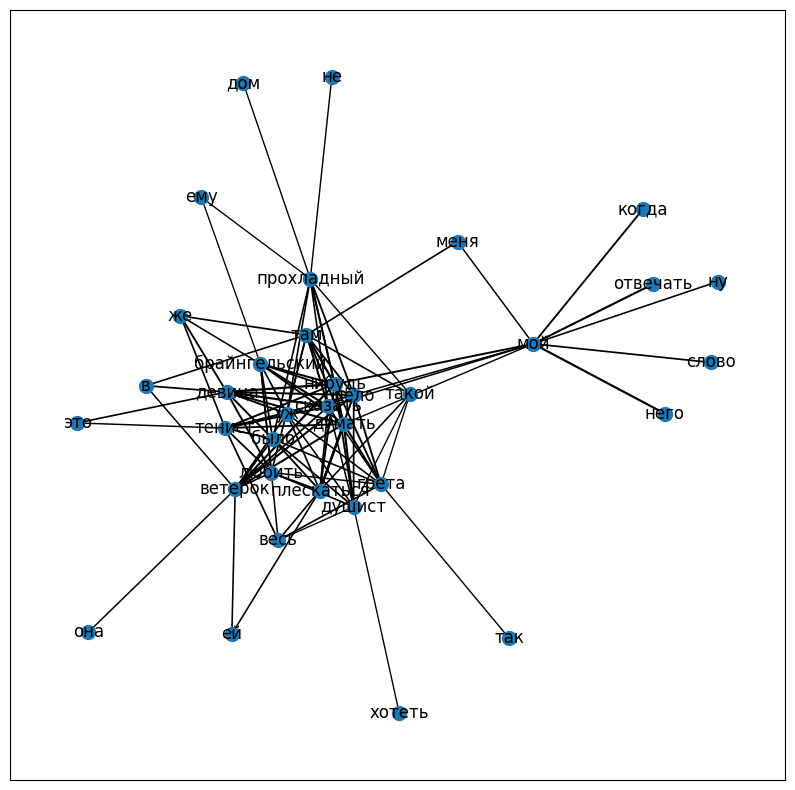

In [142]:
plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[0])
cc_nodes = list(nx.connected_components(graph))[0]
subgraph = graph.subgraph(cc_nodes)
weights = np.array(list(nx.get_edge_attributes(subgraph, 'weight').values()))
nx.draw_networkx(subgraph, node_size=100, width=weights/4)

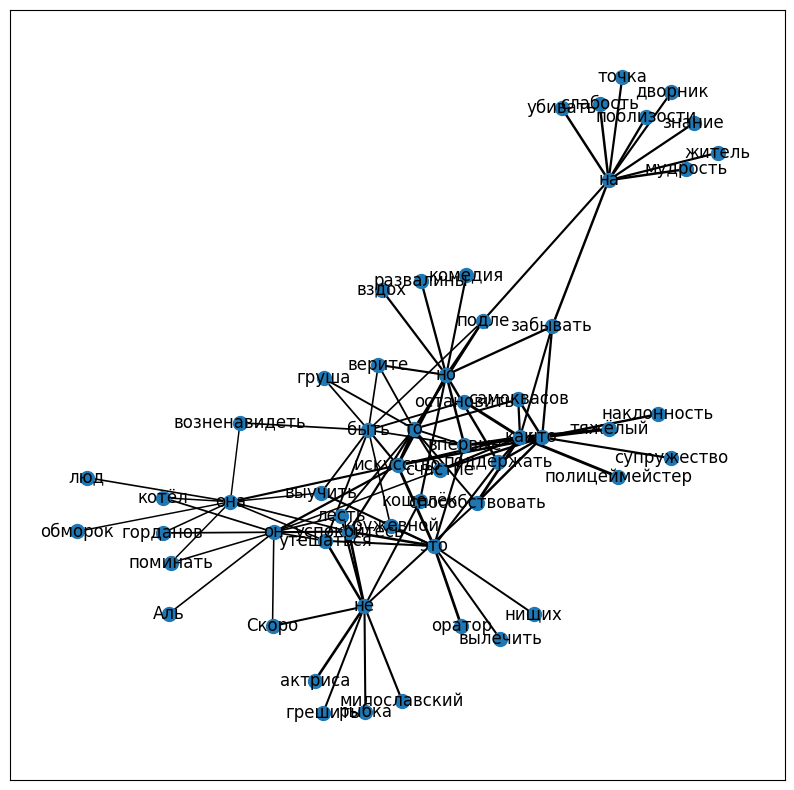

In [143]:
plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[1500])
cc_nodes = list(nx.connected_components(graph))[0]
subgraph = graph.subgraph(cc_nodes)
weights = np.array(list(nx.get_edge_attributes(subgraph, 'weight').values()))
nx.draw_networkx(subgraph, node_size=100, width=weights/4)

In [144]:
core_edges = []
multiple_edges = []
boundary_edges = []
multiple_nodes = []
boundary_nodes = []

min_core_node_weight = []
max_core_node_weight = []
avg_core_node_weight = []
sum_core_node_weight = []
min_multiple_node_weight = []
max_multiple_node_weight = []
avg_multiple_node_weight = []
sum_multiple_node_weight = []
min_boundary_node_weight = []
max_boundary_node_weight = []
avg_boundary_node_weight = []
sum_boundary_node_weight = []

min_core_edge_weight = []
max_core_edge_weight = []
avg_core_edge_weight = []
sum_core_edge_weight = []
min_multiple_edge_weight = []
max_multiple_edge_weight = []
avg_multiple_edge_weight = []
sum_multiple_edge_weight = []
min_boundary_edge_weight = []
max_boundary_edge_weight = []
avg_boundary_edge_weight = []
sum_boundary_edge_weight = []

min_core_core_degree = []
max_core_core_degree = []
avg_core_core_degree = []
sum_core_core_degree = []
min_core_multiple_degree = []
max_core_multiple_degree = []
avg_core_multiple_degree = []
sum_core_multiple_degree = []
min_core_boundary_degree = []
max_core_boundary_degree = []
avg_core_boundary_degree = []
sum_core_boundary_degree = []

for graph in tqdm(graphs):
    edge_counter = Counter(nx.get_edge_attributes(graph, 'edge_type').values())
    node_counter = Counter(nx.get_node_attributes(graph, 'node_type').values())
    core_edges.append(edge_counter['core'])
    multiple_edges.append(edge_counter['multiple'])
    boundary_edges.append(edge_counter['boundary'])
    multiple_nodes.append(node_counter['multiple'])
    boundary_nodes.append(node_counter['boundary'])
    
    # node aggregation
    core_node_weight = []
    multiple_node_weight = []
    boundary_node_weight = []
    for node in graph.nodes:
        if graph.nodes[node]['node_type'] == 'core':
            core_node_weight.append(graph.nodes[node]['node_weight'])
        elif graph.nodes[node]['node_type'] == 'multiple':
            multiple_node_weight.append(graph.nodes[node]['node_weight'])
        else:
            boundary_node_weight.append(graph.nodes[node]['node_weight'])
    min_core_node_weight.append(min(core_node_weight))
    max_core_node_weight.append(max(core_node_weight))
    avg_core_node_weight.append(np.mean(core_node_weight))
    sum_core_node_weight.append(sum(core_node_weight))
    min_multiple_node_weight.append(min(multiple_node_weight))
    max_multiple_node_weight.append(max(multiple_node_weight))
    avg_multiple_node_weight.append(np.mean(multiple_node_weight))
    sum_multiple_node_weight.append(sum(multiple_node_weight))
    boundary_node_weight = [0] if not boundary_node_weight else boundary_node_weight
    min_boundary_node_weight.append(min(boundary_node_weight))
    max_boundary_node_weight.append(max(boundary_node_weight))
    avg_boundary_node_weight.append(np.mean(boundary_node_weight))
    sum_boundary_node_weight.append(sum(boundary_node_weight))
    
    # edge aggregation
    core_edge_weight = []
    multiple_edge_weight = []
    boundary_edge_weight = []
    for edge in graph.edges:
        if graph.edges[edge]['edge_type'] == 'core':
            core_edge_weight.append(graph.edges[edge]['weight'])
        elif graph.edges[edge]['edge_type'] == 'multiple':
            multiple_edge_weight.append(graph.edges[edge]['weight'])
        else:
            boundary_edge_weight.append(graph.edges[edge]['weight'])
    core_edge_weight = [0] if not core_edge_weight else core_edge_weight
    min_core_edge_weight.append(min(core_edge_weight))
    max_core_edge_weight.append(max(core_edge_weight))
    avg_core_edge_weight.append(np.mean(core_edge_weight))
    sum_core_edge_weight.append(sum(core_edge_weight))
    min_multiple_edge_weight.append(min(multiple_edge_weight))
    max_multiple_edge_weight.append(max(multiple_edge_weight))
    avg_multiple_edge_weight.append(np.mean(multiple_edge_weight))
    sum_multiple_edge_weight.append(sum(multiple_edge_weight))
    boundary_edge_weight = [0] if not boundary_edge_weight else boundary_edge_weight
    min_boundary_edge_weight.append(min(boundary_edge_weight))
    max_boundary_edge_weight.append(max(boundary_edge_weight))
    avg_boundary_edge_weight.append(np.mean(boundary_edge_weight))
    sum_boundary_edge_weight.append(sum(boundary_edge_weight))
    
    # degree aggregation
    core_core_degree = []
    core_multiple_degree = []
    core_boundary_degree = []
    for core_node in graph.nodes:
        if graph.nodes[core_node]['node_type'] != 'core':
            continue
        degree_counter = Counter([value for (u, v, value) in graph.edges(core_node, data='edge_type')])
        core_core_degree.append(degree_counter['core'])
        core_multiple_degree.append(degree_counter['multiple'])
        core_boundary_degree.append(degree_counter['boundary'])
    
    min_core_core_degree.append(min(core_core_degree))
    max_core_core_degree.append(max(core_core_degree))
    avg_core_core_degree.append(np.mean(core_core_degree))
    sum_core_core_degree.append(sum(core_core_degree))
    min_core_multiple_degree.append(min(core_multiple_degree))
    max_core_multiple_degree.append(max(core_multiple_degree))
    avg_core_multiple_degree.append(np.mean(core_multiple_degree))
    sum_core_multiple_degree.append(sum(core_multiple_degree))
    core_boundary_degree = [0] if not core_boundary_degree else core_boundary_degree
    min_core_boundary_degree.append(min(core_boundary_degree))
    max_core_boundary_degree.append(max(core_boundary_degree))
    avg_core_boundary_degree.append(np.mean(core_boundary_degree))
    sum_core_boundary_degree.append(sum(core_boundary_degree))

  0%|          | 0/1826 [00:00<?, ?it/s]

In [146]:
graph_feat = pd.DataFrame({
    'text_len': text_len,
    'core_edges': core_edges,
    'multiple_edges': multiple_edges,
    'boundary_edges': boundary_edges,
    'multiple_nodes': multiple_nodes,
    'boundary_nodes': boundary_nodes,
    'min_core_node_weight': min_core_node_weight,
    'max_core_node_weight': max_core_node_weight,
    'avg_core_node_weight': avg_core_node_weight,
    'sum_core_node_weight': sum_core_node_weight,
    'min_multiple_node_weight': min_multiple_node_weight,
    'max_multiple_node_weight': max_multiple_node_weight,
    'avg_multiple_node_weight': avg_multiple_node_weight,
    'sum_multiple_node_weight': sum_multiple_node_weight,
    'min_boundary_node_weight': min_boundary_node_weight,
    'max_boundary_node_weight': max_boundary_node_weight,
    'avg_boundary_node_weight': avg_boundary_node_weight,
    'sum_boundary_node_weight': sum_boundary_node_weight,
    'min_core_edge_weight': min_core_edge_weight,
    'max_core_edge_weight': max_core_edge_weight,
    'avg_core_edge_weight': avg_core_edge_weight,
    'sum_core_edge_weight': sum_core_edge_weight,
    'min_multiple_edge_weight': min_multiple_edge_weight,
    'max_multiple_edge_weight': max_multiple_edge_weight,
    'avg_multiple_edge_weight': avg_multiple_edge_weight,
    'sum_multiple_edge_weight': sum_multiple_edge_weight,
    'min_boundary_edge_weight': min_boundary_edge_weight,
    'max_boundary_edge_weight': max_boundary_edge_weight,
    'avg_boundary_edge_weight': avg_boundary_edge_weight,
    'sum_boundary_edge_weight': sum_boundary_edge_weight,
    'min_core_core_degree': min_core_core_degree,
    'max_core_core_degree': max_core_core_degree,
    'avg_core_core_degree': avg_core_core_degree,
    'sum_core_core_degree': sum_core_core_degree,
    'min_core_multiple_degree': min_core_multiple_degree,
    'max_core_multiple_degree': max_core_multiple_degree,
    'avg_core_multiple_degree': avg_core_multiple_degree,
    'sum_core_multiple_degree': sum_core_multiple_degree,
    'min_core_boundary_degree': min_core_boundary_degree,
    'max_core_boundary_degree': max_core_boundary_degree,
    'avg_core_boundary_degree': avg_core_boundary_degree,
    'sum_core_boundary_degree': sum_core_boundary_degree,
})
graph_feat.iloc[0]

text_len                                 217
core_edges                                 0
multiple_edges                            90
boundary_edges                            10
multiple_nodes                            15
boundary_nodes                            10
min_core_node_weight                0.023041
max_core_node_weight                0.036866
avg_core_node_weight                0.029032
sum_core_node_weight                0.290323
min_multiple_node_weight                 0.0
max_multiple_node_weight            0.004608
avg_multiple_node_weight            0.000922
sum_multiple_node_weight            0.013825
min_boundary_node_weight                 0.0
max_boundary_node_weight            0.018433
avg_boundary_node_weight            0.002765
sum_boundary_node_weight             0.02765
min_core_edge_weight                       0
max_core_edge_weight                       0
avg_core_edge_weight                     0.0
sum_core_edge_weight                       0
min_multip

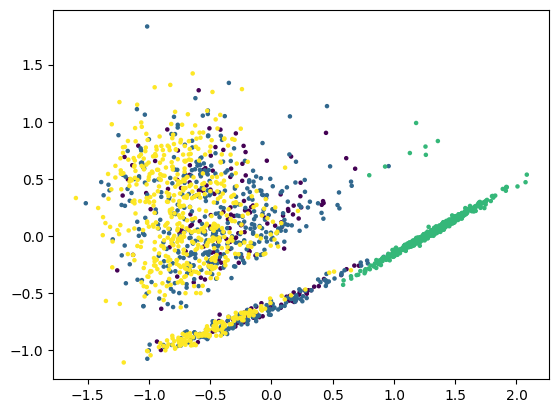

In [147]:
pca = PCA(n_components=16)
emb = pca.fit_transform(minmax_scale(graph_feat))
plt.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(true_labels), s=5)

In [156]:
clustering = SpectralClustering(
    n_clusters=4, 
    n_neighbors=6,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
)
pred_labels = clustering.fit_predict(emb)

In [157]:
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}'''
)

homogeneity_score: 0.3167
completeness_score: 0.3901
v_measure_score: 0.3496
adjusted_rand_score: 0.2562


In [160]:
kmeans = KMeans(
    n_clusters=4,
    max_iter=100,
    n_init=1
    )

pred_labels = kmeans.fit_predict(emb)

print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}
silhouette_score: {metrics.silhouette_score(emb, pred_labels, sample_size=2000):.4f}'''
)

homogeneity_score: 0.4221
completeness_score: 0.4046
v_measure_score: 0.4132
adjusted_rand_score: 0.3754
silhouette_score: 0.3464


genre clustering with stop word removal

In [15]:
STOP_WORDS = set(
    """
а авось ага агу аж ай али алло ау ах ая

б будем будет будете будешь буду будут будучи будь будьте бы был была были было
быть бац без безусловно бишь благо благодаря ближайшие близко более больше
будто бывает бывала бывали бываю бывают бытует

в вам вами вас весь во вот все всё всего всей всем всём всеми всему всех всею
всея всю вся вы ваш ваша ваше ваши вдали вдобавок вдруг ведь везде вернее
взаимно взаправду видно вишь включая вместо внакладе вначале вне вниз внизу
вновь вовсе возможно воистину вокруг вон вообще вопреки вперекор вплоть
вполне вправду вправе впрочем впрямь вресноту вроде вряд всегда всюду
всякий всякого всякой всячески вчеред

г го где гораздо гав

д да для до дабы давайте давно давным даже далее далеко дальше данная
данного данное данной данном данному данные данный данных дану данунах
даром де действительно довольно доколе доколь долго должен должна
должно должны должный дополнительно другая другие другим другими
других другое другой

е его едим едят ее её ей ел ела ем ему емъ если ест есть ешь еще ещё ею едва
ежели еле

ж же

з за затем зато зачем здесь значит зря

и из или им ими имъ их ибо иль имеет имел имела имело именно иметь иначе
иногда иным иными итак ишь

й

к как кем ко когда кого ком кому комья которая которого которое которой котором
которому которою которую которые который которым которыми которых кто ка кабы
каждая каждое каждые каждый кажется казалась казались казалось казался казаться
какая какие каким какими каков какого какой какому какою касательно кой коли
коль конечно короче кроме кстати ку куда

л ли либо лишь любая любого любое любой любом любую любыми любых

м меня мне мной мною мог моги могите могла могли могло могу могут мое моё моего
моей моем моём моему моею можем может можете можешь мои мой моим моими моих
мочь мою моя мы мало меж между менее меньше мимо многие много многого многое
многом многому можно мол му

н на нам нами нас наса наш наша наше нашего нашей нашем нашему нашею наши нашим
нашими наших нашу не него нее неё ней нем нём нему нет нею ним ними них но
наверняка наверху навряд навыворот над надо назад наиболее наизворот
наизнанку наипаче накануне наконец наоборот наперед наперекор наподобие
например напротив напрямую насилу настоящая настоящее настоящие настоящий
насчет нате находиться начала начале неважно негде недавно недалеко незачем
некем некогда некому некоторая некоторые некоторый некоторых некто некуда
нельзя немногие немногим немного необходимо необходимости необходимые
необходимым неоткуда непрерывно нередко несколько нету неужели нечего
нечем нечему нечто нешто нибудь нигде ниже низко никак никакой никем
никогда никого никому никто никуда ниоткуда нипочем ничего ничем ничему
ничто ну нужная нужно нужного нужные нужный нужных ныне нынешнее нынешней
нынешних нынче

о об один одна одни одним одними одних одно одного одной одном одному одною
одну он она оне они оно от оба общую обычно ого однажды однако ой около оный
оп опять особенно особо особую особые откуда отнелижа отнелиже отовсюду
отсюда оттого оттот оттуда отчего отчему ох очевидно очень ом

п по при паче перед под подавно поди подобная подобно подобного подобные
подобный подобным подобных поелику пожалуй пожалуйста позже поистине
пока покамест поколе поколь покуда покудова помимо понеже поприще пор
пора посему поскольку после посреди посредством потом потому потомушта
похожем почему почти поэтому прежде притом причем про просто прочего
прочее прочему прочими проще прям пусть

р ради разве ранее рано раньше рядом

с сам сама сами самим самими самих само самого самом самому саму свое своё
своего своей своем своём своему своею свои свой своим своими своих свою своя
себе себя собой собою самая самое самой самый самых сверх свыше се сего сей
сейчас сие сих сквозь сколько скорее скоро следует слишком смогут сможет
сначала снова со собственно совсем сперва спокону спустя сразу среди сродни
стал стала стали стало стать суть сызнова

та то ту ты ти так такая такие таким такими таких такого такое такой таком такому такою
такую те тебе тебя тем теми тех тобой тобою того той только том томах тому
тот тою также таки таков такова там твои твоим твоих твой твоя твоё
теперь тогда тоже тотчас точно туда тут тьфу тая

у уже увы уж ура ух ую

ф фу

х ха хе хорошо хотел хотела хотелось хотеть хоть хотя хочешь хочу хуже

ч чего чем чём чему что чтобы часто чаще чей через чтоб чуть чхать чьим
чьих чьё чё

ш ша

щ ща щас

ы ых ые ый

э эта эти этим этими этих это этого этой этом этому этот этою эту эдак эдакий
эй эка экий этак этакий эх

ю

я явно явных яко якобы якоже
""".split()
)

In [16]:
#np.random.seed(0)
#random_num = np.random.randint(1826, size=100)
graphs = []
text_len = []

for num_sentence, sentence in enumerate(tqdm(texts_)):
    #if num_sentence not in random_num:
    #    continue
    if not sentence:
        continue
    clean = [word for word in sentence if word not in STOP_WORDS]
    sentence = clean
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    sent_vocab = vocab.lookup_indices(list(set(sentence)))
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    probs = getprob([x[0] for x in top10])
    filtered = torch.index_select(probs, 2, torch.tensor(sent_vocab))
    for num, (word_i, count) in enumerate(top10):
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        w_probs = filtered[num]
        probs_, indeces = torch.sort(w_probs, descending=True)
        syns = [vocab.lookup_token(i) for i in indeces[0][:10]]
        for num, word_j in enumerate(syns):
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, probs_[0][num]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

  0%|          | 0/1826 [00:00<?, ?it/s]

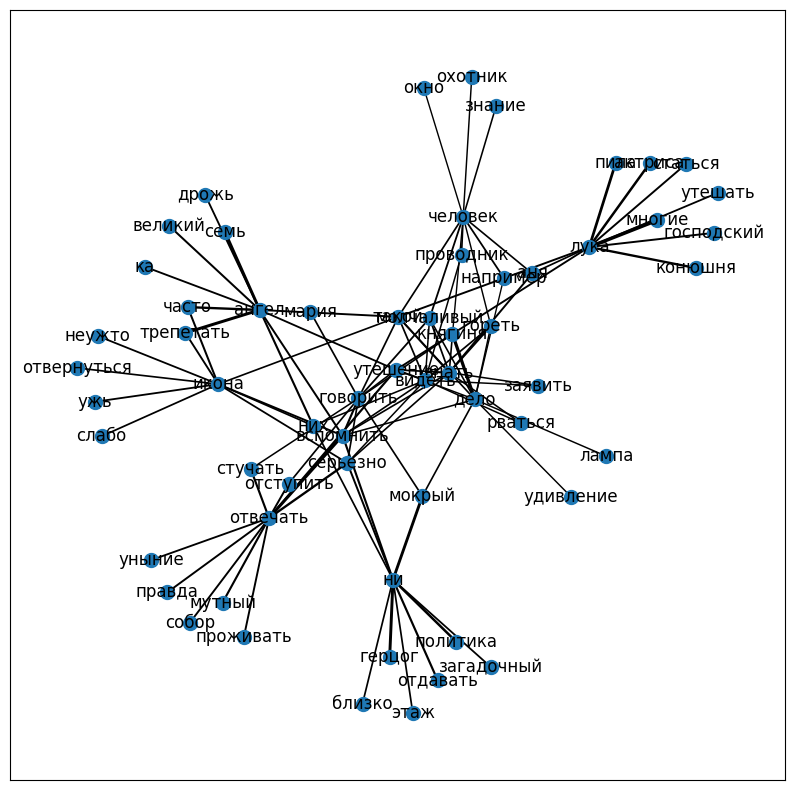

In [21]:
plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[1800])
weights = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))
nx.draw_networkx(graph, node_size=100, width=weights/4)

In [22]:
core_edges = []
multiple_edges = []
boundary_edges = []
multiple_nodes = []
boundary_nodes = []

min_core_node_weight = []
max_core_node_weight = []
avg_core_node_weight = []
sum_core_node_weight = []
min_multiple_node_weight = []
max_multiple_node_weight = []
avg_multiple_node_weight = []
sum_multiple_node_weight = []
min_boundary_node_weight = []
max_boundary_node_weight = []
avg_boundary_node_weight = []
sum_boundary_node_weight = []

min_core_edge_weight = []
max_core_edge_weight = []
avg_core_edge_weight = []
sum_core_edge_weight = []
min_multiple_edge_weight = []
max_multiple_edge_weight = []
avg_multiple_edge_weight = []
sum_multiple_edge_weight = []
min_boundary_edge_weight = []
max_boundary_edge_weight = []
avg_boundary_edge_weight = []
sum_boundary_edge_weight = []

min_core_core_degree = []
max_core_core_degree = []
avg_core_core_degree = []
sum_core_core_degree = []
min_core_multiple_degree = []
max_core_multiple_degree = []
avg_core_multiple_degree = []
sum_core_multiple_degree = []
min_core_boundary_degree = []
max_core_boundary_degree = []
avg_core_boundary_degree = []
sum_core_boundary_degree = []

for graph in tqdm(graphs):
    edge_counter = Counter(nx.get_edge_attributes(graph, 'edge_type').values())
    node_counter = Counter(nx.get_node_attributes(graph, 'node_type').values())
    core_edges.append(edge_counter['core'])
    multiple_edges.append(edge_counter['multiple'])
    boundary_edges.append(edge_counter['boundary'])
    multiple_nodes.append(node_counter['multiple'])
    boundary_nodes.append(node_counter['boundary'])
    
    # node aggregation
    core_node_weight = []
    multiple_node_weight = []
    boundary_node_weight = []
    for node in graph.nodes:
        if graph.nodes[node]['node_type'] == 'core':
            core_node_weight.append(graph.nodes[node]['node_weight'])
        elif graph.nodes[node]['node_type'] == 'multiple':
            multiple_node_weight.append(graph.nodes[node]['node_weight'])
        else:
            boundary_node_weight.append(graph.nodes[node]['node_weight'])
    min_core_node_weight.append(min(core_node_weight))
    max_core_node_weight.append(max(core_node_weight))
    avg_core_node_weight.append(np.mean(core_node_weight))
    sum_core_node_weight.append(sum(core_node_weight))
    min_multiple_node_weight.append(min(multiple_node_weight))
    max_multiple_node_weight.append(max(multiple_node_weight))
    avg_multiple_node_weight.append(np.mean(multiple_node_weight))
    sum_multiple_node_weight.append(sum(multiple_node_weight))
    boundary_node_weight = [0] if not boundary_node_weight else boundary_node_weight
    min_boundary_node_weight.append(min(boundary_node_weight))
    max_boundary_node_weight.append(max(boundary_node_weight))
    avg_boundary_node_weight.append(np.mean(boundary_node_weight))
    sum_boundary_node_weight.append(sum(boundary_node_weight))
    
    # edge aggregation
    core_edge_weight = []
    multiple_edge_weight = []
    boundary_edge_weight = []
    for edge in graph.edges:
        if graph.edges[edge]['edge_type'] == 'core':
            core_edge_weight.append(graph.edges[edge]['weight'])
        elif graph.edges[edge]['edge_type'] == 'multiple':
            multiple_edge_weight.append(graph.edges[edge]['weight'])
        else:
            boundary_edge_weight.append(graph.edges[edge]['weight'])
    core_edge_weight = [0] if not core_edge_weight else core_edge_weight
    min_core_edge_weight.append(min(core_edge_weight))
    max_core_edge_weight.append(max(core_edge_weight))
    avg_core_edge_weight.append(np.mean(core_edge_weight))
    sum_core_edge_weight.append(sum(core_edge_weight))
    min_multiple_edge_weight.append(min(multiple_edge_weight))
    max_multiple_edge_weight.append(max(multiple_edge_weight))
    avg_multiple_edge_weight.append(np.mean(multiple_edge_weight))
    sum_multiple_edge_weight.append(sum(multiple_edge_weight))
    boundary_edge_weight = [0] if not boundary_edge_weight else boundary_edge_weight
    min_boundary_edge_weight.append(min(boundary_edge_weight))
    max_boundary_edge_weight.append(max(boundary_edge_weight))
    avg_boundary_edge_weight.append(np.mean(boundary_edge_weight))
    sum_boundary_edge_weight.append(sum(boundary_edge_weight))
    
    # degree aggregation
    core_core_degree = []
    core_multiple_degree = []
    core_boundary_degree = []
    for core_node in graph.nodes:
        if graph.nodes[core_node]['node_type'] != 'core':
            continue
        degree_counter = Counter([value for (u, v, value) in graph.edges(core_node, data='edge_type')])
        core_core_degree.append(degree_counter['core'])
        core_multiple_degree.append(degree_counter['multiple'])
        core_boundary_degree.append(degree_counter['boundary'])
    
    min_core_core_degree.append(min(core_core_degree))
    max_core_core_degree.append(max(core_core_degree))
    avg_core_core_degree.append(np.mean(core_core_degree))
    sum_core_core_degree.append(sum(core_core_degree))
    min_core_multiple_degree.append(min(core_multiple_degree))
    max_core_multiple_degree.append(max(core_multiple_degree))
    avg_core_multiple_degree.append(np.mean(core_multiple_degree))
    sum_core_multiple_degree.append(sum(core_multiple_degree))
    core_boundary_degree = [0] if not core_boundary_degree else core_boundary_degree
    min_core_boundary_degree.append(min(core_boundary_degree))
    max_core_boundary_degree.append(max(core_boundary_degree))
    avg_core_boundary_degree.append(np.mean(core_boundary_degree))
    sum_core_boundary_degree.append(sum(core_boundary_degree))

  0%|          | 0/1826 [00:00<?, ?it/s]

In [23]:
graph_feat = pd.DataFrame({
    'text_len': text_len,
    'core_edges': core_edges,
    'multiple_edges': multiple_edges,
    'boundary_edges': boundary_edges,
    'multiple_nodes': multiple_nodes,
    'boundary_nodes': boundary_nodes,
    'min_core_node_weight': min_core_node_weight,
    'max_core_node_weight': max_core_node_weight,
    'avg_core_node_weight': avg_core_node_weight,
    'sum_core_node_weight': sum_core_node_weight,
    'min_multiple_node_weight': min_multiple_node_weight,
    'max_multiple_node_weight': max_multiple_node_weight,
    'avg_multiple_node_weight': avg_multiple_node_weight,
    'sum_multiple_node_weight': sum_multiple_node_weight,
    'min_boundary_node_weight': min_boundary_node_weight,
    'max_boundary_node_weight': max_boundary_node_weight,
    'avg_boundary_node_weight': avg_boundary_node_weight,
    'sum_boundary_node_weight': sum_boundary_node_weight,
    'min_core_edge_weight': min_core_edge_weight,
    'max_core_edge_weight': max_core_edge_weight,
    'avg_core_edge_weight': avg_core_edge_weight,
    'sum_core_edge_weight': sum_core_edge_weight,
    'min_multiple_edge_weight': min_multiple_edge_weight,
    'max_multiple_edge_weight': max_multiple_edge_weight,
    'avg_multiple_edge_weight': avg_multiple_edge_weight,
    'sum_multiple_edge_weight': sum_multiple_edge_weight,
    'min_boundary_edge_weight': min_boundary_edge_weight,
    'max_boundary_edge_weight': max_boundary_edge_weight,
    'avg_boundary_edge_weight': avg_boundary_edge_weight,
    'sum_boundary_edge_weight': sum_boundary_edge_weight,
    'min_core_core_degree': min_core_core_degree,
    'max_core_core_degree': max_core_core_degree,
    'avg_core_core_degree': avg_core_core_degree,
    'sum_core_core_degree': sum_core_core_degree,
    'min_core_multiple_degree': min_core_multiple_degree,
    'max_core_multiple_degree': max_core_multiple_degree,
    'avg_core_multiple_degree': avg_core_multiple_degree,
    'sum_core_multiple_degree': sum_core_multiple_degree,
    'min_core_boundary_degree': min_core_boundary_degree,
    'max_core_boundary_degree': max_core_boundary_degree,
    'avg_core_boundary_degree': avg_core_boundary_degree,
    'sum_core_boundary_degree': sum_core_boundary_degree,
})
graph_feat.iloc[0]

text_len                                 154
core_edges                                 0
multiple_edges                            93
boundary_edges                             7
multiple_nodes                            20
boundary_nodes                             7
min_core_node_weight                0.019481
max_core_node_weight                0.045455
avg_core_node_weight                0.035065
sum_core_node_weight                0.350649
min_multiple_node_weight                 0.0
max_multiple_node_weight                 0.0
avg_multiple_node_weight                 0.0
sum_multiple_node_weight                 0.0
min_boundary_node_weight                 0.0
max_boundary_node_weight            0.012987
avg_boundary_node_weight            0.002783
sum_boundary_node_weight            0.019481
min_core_edge_weight                       0
max_core_edge_weight                       0
avg_core_edge_weight                     0.0
sum_core_edge_weight                       0
min_multip

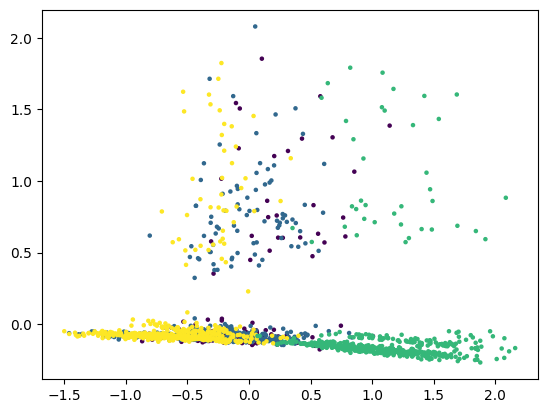

In [24]:
pca = PCA(n_components=16)
emb = pca.fit_transform(minmax_scale(graph_feat))
plt.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(true_labels), s=5)

In [25]:
clustering = SpectralClustering(
    n_clusters=4, 
    n_neighbors=6,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
)
pred_labels = clustering.fit_predict(emb)

print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}'''
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


homogeneity_score: 0.3690
completeness_score: 0.4709
v_measure_score: 0.4137
adjusted_rand_score: 0.3218


authors

In [26]:
novels = [num for num, genre in enumerate(true_labels) if genre == 'novels']
novels_text = [text for num, text in enumerate(texts) if num in novels]
novels_authors = [text for num, text in enumerate(authors) if num in novels]
selected_authors = [i[0] for i in Counter(novels_authors).most_common(10)]
indeces = [num for num, author in enumerate(authors) if author in selected_authors]

sentences = [texts[num] for num in indeces] # selected 148 novels of top10 authors

In [27]:
true_labels = [authors[num] for num in indeces]

In [28]:
texts_ = []
for text in sentences:
    text_clean = []
    for w in text:
        if w not in not_in_vocab:
            text_clean.append(w)
    texts_.append(text_clean)

In [173]:
graphs = []
text_len = []

for num_sentence, sentence in enumerate(tqdm(texts_)):
    if not sentence:
        continue
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    sent_vocab = vocab.lookup_indices(list(set(sentence)))
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    probs = getprob([x[0] for x in top10])
    filtered = torch.index_select(probs, 2, torch.tensor(sent_vocab))
    for num, (word_i, count) in enumerate(top10):
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        w_probs = filtered[num]
        probs_, indeces = torch.sort(w_probs, descending=True)
        syns = [vocab.lookup_token(i) for i in indeces[0][:10]]
        for num, word_j in enumerate(syns):
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, probs_[0][num]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

  0%|          | 0/148 [00:00<?, ?it/s]

In [174]:
core_edges = []
multiple_edges = []
boundary_edges = []
multiple_nodes = []
boundary_nodes = []

min_core_node_weight = []
max_core_node_weight = []
avg_core_node_weight = []
sum_core_node_weight = []
min_multiple_node_weight = []
max_multiple_node_weight = []
avg_multiple_node_weight = []
sum_multiple_node_weight = []
min_boundary_node_weight = []
max_boundary_node_weight = []
avg_boundary_node_weight = []
sum_boundary_node_weight = []

min_core_edge_weight = []
max_core_edge_weight = []
avg_core_edge_weight = []
sum_core_edge_weight = []
min_multiple_edge_weight = []
max_multiple_edge_weight = []
avg_multiple_edge_weight = []
sum_multiple_edge_weight = []
min_boundary_edge_weight = []
max_boundary_edge_weight = []
avg_boundary_edge_weight = []
sum_boundary_edge_weight = []

min_core_core_degree = []
max_core_core_degree = []
avg_core_core_degree = []
sum_core_core_degree = []
min_core_multiple_degree = []
max_core_multiple_degree = []
avg_core_multiple_degree = []
sum_core_multiple_degree = []
min_core_boundary_degree = []
max_core_boundary_degree = []
avg_core_boundary_degree = []
sum_core_boundary_degree = []

for graph in tqdm(graphs):
    edge_counter = Counter(nx.get_edge_attributes(graph, 'edge_type').values())
    node_counter = Counter(nx.get_node_attributes(graph, 'node_type').values())
    core_edges.append(edge_counter['core'])
    multiple_edges.append(edge_counter['multiple'])
    boundary_edges.append(edge_counter['boundary'])
    multiple_nodes.append(node_counter['multiple'])
    boundary_nodes.append(node_counter['boundary'])
    
    # node aggregation
    core_node_weight = []
    multiple_node_weight = []
    boundary_node_weight = []
    for node in graph.nodes:
        if graph.nodes[node]['node_type'] == 'core':
            core_node_weight.append(graph.nodes[node]['node_weight'])
        elif graph.nodes[node]['node_type'] == 'multiple':
            multiple_node_weight.append(graph.nodes[node]['node_weight'])
        else:
            boundary_node_weight.append(graph.nodes[node]['node_weight'])
    min_core_node_weight.append(min(core_node_weight))
    max_core_node_weight.append(max(core_node_weight))
    avg_core_node_weight.append(np.mean(core_node_weight))
    sum_core_node_weight.append(sum(core_node_weight))
    min_multiple_node_weight.append(min(multiple_node_weight))
    max_multiple_node_weight.append(max(multiple_node_weight))
    avg_multiple_node_weight.append(np.mean(multiple_node_weight))
    sum_multiple_node_weight.append(sum(multiple_node_weight))
    boundary_node_weight = [0] if not boundary_node_weight else boundary_node_weight
    min_boundary_node_weight.append(min(boundary_node_weight))
    max_boundary_node_weight.append(max(boundary_node_weight))
    avg_boundary_node_weight.append(np.mean(boundary_node_weight))
    sum_boundary_node_weight.append(sum(boundary_node_weight))
    
    # edge aggregation
    core_edge_weight = []
    multiple_edge_weight = []
    boundary_edge_weight = []
    for edge in graph.edges:
        if graph.edges[edge]['edge_type'] == 'core':
            core_edge_weight.append(graph.edges[edge]['weight'])
        elif graph.edges[edge]['edge_type'] == 'multiple':
            multiple_edge_weight.append(graph.edges[edge]['weight'])
        else:
            boundary_edge_weight.append(graph.edges[edge]['weight'])
    core_edge_weight = [0] if not core_edge_weight else core_edge_weight
    min_core_edge_weight.append(min(core_edge_weight))
    max_core_edge_weight.append(max(core_edge_weight))
    avg_core_edge_weight.append(np.mean(core_edge_weight))
    sum_core_edge_weight.append(sum(core_edge_weight))
    min_multiple_edge_weight.append(min(multiple_edge_weight))
    max_multiple_edge_weight.append(max(multiple_edge_weight))
    avg_multiple_edge_weight.append(np.mean(multiple_edge_weight))
    sum_multiple_edge_weight.append(sum(multiple_edge_weight))
    boundary_edge_weight = [0] if not boundary_edge_weight else boundary_edge_weight
    min_boundary_edge_weight.append(min(boundary_edge_weight))
    max_boundary_edge_weight.append(max(boundary_edge_weight))
    avg_boundary_edge_weight.append(np.mean(boundary_edge_weight))
    sum_boundary_edge_weight.append(sum(boundary_edge_weight))
    
    # degree aggregation
    core_core_degree = []
    core_multiple_degree = []
    core_boundary_degree = []
    for core_node in graph.nodes:
        if graph.nodes[core_node]['node_type'] != 'core':
            continue
        degree_counter = Counter([value for (u, v, value) in graph.edges(core_node, data='edge_type')])
        core_core_degree.append(degree_counter['core'])
        core_multiple_degree.append(degree_counter['multiple'])
        core_boundary_degree.append(degree_counter['boundary'])
    
    min_core_core_degree.append(min(core_core_degree))
    max_core_core_degree.append(max(core_core_degree))
    avg_core_core_degree.append(np.mean(core_core_degree))
    sum_core_core_degree.append(sum(core_core_degree))
    min_core_multiple_degree.append(min(core_multiple_degree))
    max_core_multiple_degree.append(max(core_multiple_degree))
    avg_core_multiple_degree.append(np.mean(core_multiple_degree))
    sum_core_multiple_degree.append(sum(core_multiple_degree))
    core_boundary_degree = [0] if not core_boundary_degree else core_boundary_degree
    min_core_boundary_degree.append(min(core_boundary_degree))
    max_core_boundary_degree.append(max(core_boundary_degree))
    avg_core_boundary_degree.append(np.mean(core_boundary_degree))
    sum_core_boundary_degree.append(sum(core_boundary_degree))

  0%|          | 0/148 [00:00<?, ?it/s]

In [175]:
graph_feat = pd.DataFrame({
    'text_len': text_len,
    'core_edges': core_edges,
    'multiple_edges': multiple_edges,
    'boundary_edges': boundary_edges,
    'multiple_nodes': multiple_nodes,
    'boundary_nodes': boundary_nodes,
    'min_core_node_weight': min_core_node_weight,
    'max_core_node_weight': max_core_node_weight,
    'avg_core_node_weight': avg_core_node_weight,
    'sum_core_node_weight': sum_core_node_weight,
    'min_multiple_node_weight': min_multiple_node_weight,
    'max_multiple_node_weight': max_multiple_node_weight,
    'avg_multiple_node_weight': avg_multiple_node_weight,
    'sum_multiple_node_weight': sum_multiple_node_weight,
    'min_boundary_node_weight': min_boundary_node_weight,
    'max_boundary_node_weight': max_boundary_node_weight,
    'avg_boundary_node_weight': avg_boundary_node_weight,
    'sum_boundary_node_weight': sum_boundary_node_weight,
    'min_core_edge_weight': min_core_edge_weight,
    'max_core_edge_weight': max_core_edge_weight,
    'avg_core_edge_weight': avg_core_edge_weight,
    'sum_core_edge_weight': sum_core_edge_weight,
    'min_multiple_edge_weight': min_multiple_edge_weight,
    'max_multiple_edge_weight': max_multiple_edge_weight,
    'avg_multiple_edge_weight': avg_multiple_edge_weight,
    'sum_multiple_edge_weight': sum_multiple_edge_weight,
    'min_boundary_edge_weight': min_boundary_edge_weight,
    'max_boundary_edge_weight': max_boundary_edge_weight,
    'avg_boundary_edge_weight': avg_boundary_edge_weight,
    'sum_boundary_edge_weight': sum_boundary_edge_weight,
    'min_core_core_degree': min_core_core_degree,
    'max_core_core_degree': max_core_core_degree,
    'avg_core_core_degree': avg_core_core_degree,
    'sum_core_core_degree': sum_core_core_degree,
    'min_core_multiple_degree': min_core_multiple_degree,
    'max_core_multiple_degree': max_core_multiple_degree,
    'avg_core_multiple_degree': avg_core_multiple_degree,
    'sum_core_multiple_degree': sum_core_multiple_degree,
    'min_core_boundary_degree': min_core_boundary_degree,
    'max_core_boundary_degree': max_core_boundary_degree,
    'avg_core_boundary_degree': avg_core_boundary_degree,
    'sum_core_boundary_degree': sum_core_boundary_degree,
})
graph_feat.iloc[0]

text_len                              183165
core_edges                                 0
multiple_edges                            66
boundary_edges                            34
multiple_nodes                            22
boundary_nodes                            34
min_core_node_weight                0.009685
max_core_node_weight                0.028362
avg_core_node_weight                0.015333
sum_core_node_weight                0.153332
min_multiple_node_weight                 0.0
max_multiple_node_weight            0.000317
avg_multiple_node_weight            0.000047
sum_multiple_node_weight            0.001037
min_boundary_node_weight                 0.0
max_boundary_node_weight            0.002091
avg_boundary_node_weight            0.000074
sum_boundary_node_weight            0.002522
min_core_edge_weight                       0
max_core_edge_weight                       0
avg_core_edge_weight                     0.0
sum_core_edge_weight                       0
min_multip

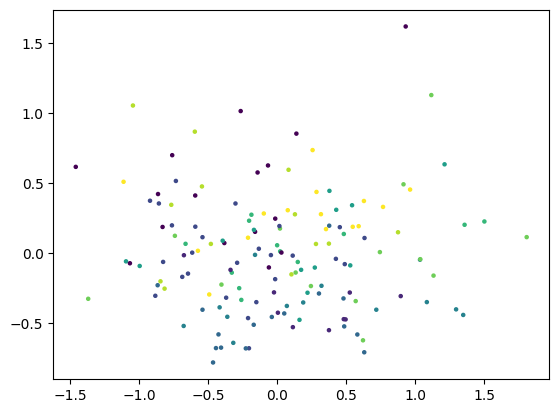

In [176]:
pca = PCA(n_components=16)
emb = pca.fit_transform(minmax_scale(graph_feat))
plt.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(true_labels), s=5)

In [178]:
clustering = SpectralClustering(
    n_clusters=10, 
    n_neighbors=6,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
)

pred_labels = clustering.fit_predict(emb)

print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}'''
)

homogeneity_score: 0.2892
completeness_score: 0.2969
v_measure_score: 0.2930
adjusted_rand_score: 0.0965


In [179]:
kmeans = KMeans(
    n_clusters=10,
    max_iter=100,
    n_init=1
    )

pred_labels = kmeans.fit_predict(emb)

print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}
silhouette_score: {metrics.silhouette_score(emb, pred_labels, sample_size=2000):.4f}'''
)

homogeneity_score: 0.2548
completeness_score: 0.2753
v_measure_score: 0.2646
adjusted_rand_score: 0.0617
silhouette_score: 0.1329


authors clustering with stop word removal

In [29]:
graphs = []
text_len = []

for num_sentence, sentence in enumerate(tqdm(texts_)):
    if not sentence:
        continue
    clean = [word for word in sentence if word not in STOP_WORDS]
    sentence = clean
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    sent_vocab = vocab.lookup_indices(list(set(sentence)))
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    probs = getprob([x[0] for x in top10])
    filtered = torch.index_select(probs, 2, torch.tensor(sent_vocab))
    for num, (word_i, count) in enumerate(top10):
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        w_probs = filtered[num]
        probs_, indeces = torch.sort(w_probs, descending=True)
        syns = [vocab.lookup_token(i) for i in indeces[0][:10]]
        for num, word_j in enumerate(syns):
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, probs_[0][num]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

  0%|          | 0/148 [00:00<?, ?it/s]

In [30]:
core_edges = []
multiple_edges = []
boundary_edges = []
multiple_nodes = []
boundary_nodes = []

min_core_node_weight = []
max_core_node_weight = []
avg_core_node_weight = []
sum_core_node_weight = []
min_multiple_node_weight = []
max_multiple_node_weight = []
avg_multiple_node_weight = []
sum_multiple_node_weight = []
min_boundary_node_weight = []
max_boundary_node_weight = []
avg_boundary_node_weight = []
sum_boundary_node_weight = []

min_core_edge_weight = []
max_core_edge_weight = []
avg_core_edge_weight = []
sum_core_edge_weight = []
min_multiple_edge_weight = []
max_multiple_edge_weight = []
avg_multiple_edge_weight = []
sum_multiple_edge_weight = []
min_boundary_edge_weight = []
max_boundary_edge_weight = []
avg_boundary_edge_weight = []
sum_boundary_edge_weight = []

min_core_core_degree = []
max_core_core_degree = []
avg_core_core_degree = []
sum_core_core_degree = []
min_core_multiple_degree = []
max_core_multiple_degree = []
avg_core_multiple_degree = []
sum_core_multiple_degree = []
min_core_boundary_degree = []
max_core_boundary_degree = []
avg_core_boundary_degree = []
sum_core_boundary_degree = []

for graph in tqdm(graphs):
    edge_counter = Counter(nx.get_edge_attributes(graph, 'edge_type').values())
    node_counter = Counter(nx.get_node_attributes(graph, 'node_type').values())
    core_edges.append(edge_counter['core'])
    multiple_edges.append(edge_counter['multiple'])
    boundary_edges.append(edge_counter['boundary'])
    multiple_nodes.append(node_counter['multiple'])
    boundary_nodes.append(node_counter['boundary'])
    
    # node aggregation
    core_node_weight = []
    multiple_node_weight = []
    boundary_node_weight = []
    for node in graph.nodes:
        if graph.nodes[node]['node_type'] == 'core':
            core_node_weight.append(graph.nodes[node]['node_weight'])
        elif graph.nodes[node]['node_type'] == 'multiple':
            multiple_node_weight.append(graph.nodes[node]['node_weight'])
        else:
            boundary_node_weight.append(graph.nodes[node]['node_weight'])
    min_core_node_weight.append(min(core_node_weight))
    max_core_node_weight.append(max(core_node_weight))
    avg_core_node_weight.append(np.mean(core_node_weight))
    sum_core_node_weight.append(sum(core_node_weight))
    min_multiple_node_weight.append(min(multiple_node_weight))
    max_multiple_node_weight.append(max(multiple_node_weight))
    avg_multiple_node_weight.append(np.mean(multiple_node_weight))
    sum_multiple_node_weight.append(sum(multiple_node_weight))
    boundary_node_weight = [0] if not boundary_node_weight else boundary_node_weight
    min_boundary_node_weight.append(min(boundary_node_weight))
    max_boundary_node_weight.append(max(boundary_node_weight))
    avg_boundary_node_weight.append(np.mean(boundary_node_weight))
    sum_boundary_node_weight.append(sum(boundary_node_weight))
    
    # edge aggregation
    core_edge_weight = []
    multiple_edge_weight = []
    boundary_edge_weight = []
    for edge in graph.edges:
        if graph.edges[edge]['edge_type'] == 'core':
            core_edge_weight.append(graph.edges[edge]['weight'])
        elif graph.edges[edge]['edge_type'] == 'multiple':
            multiple_edge_weight.append(graph.edges[edge]['weight'])
        else:
            boundary_edge_weight.append(graph.edges[edge]['weight'])
    core_edge_weight = [0] if not core_edge_weight else core_edge_weight
    min_core_edge_weight.append(min(core_edge_weight))
    max_core_edge_weight.append(max(core_edge_weight))
    avg_core_edge_weight.append(np.mean(core_edge_weight))
    sum_core_edge_weight.append(sum(core_edge_weight))
    min_multiple_edge_weight.append(min(multiple_edge_weight))
    max_multiple_edge_weight.append(max(multiple_edge_weight))
    avg_multiple_edge_weight.append(np.mean(multiple_edge_weight))
    sum_multiple_edge_weight.append(sum(multiple_edge_weight))
    boundary_edge_weight = [0] if not boundary_edge_weight else boundary_edge_weight
    min_boundary_edge_weight.append(min(boundary_edge_weight))
    max_boundary_edge_weight.append(max(boundary_edge_weight))
    avg_boundary_edge_weight.append(np.mean(boundary_edge_weight))
    sum_boundary_edge_weight.append(sum(boundary_edge_weight))
    
    # degree aggregation
    core_core_degree = []
    core_multiple_degree = []
    core_boundary_degree = []
    for core_node in graph.nodes:
        if graph.nodes[core_node]['node_type'] != 'core':
            continue
        degree_counter = Counter([value for (u, v, value) in graph.edges(core_node, data='edge_type')])
        core_core_degree.append(degree_counter['core'])
        core_multiple_degree.append(degree_counter['multiple'])
        core_boundary_degree.append(degree_counter['boundary'])
    
    min_core_core_degree.append(min(core_core_degree))
    max_core_core_degree.append(max(core_core_degree))
    avg_core_core_degree.append(np.mean(core_core_degree))
    sum_core_core_degree.append(sum(core_core_degree))
    min_core_multiple_degree.append(min(core_multiple_degree))
    max_core_multiple_degree.append(max(core_multiple_degree))
    avg_core_multiple_degree.append(np.mean(core_multiple_degree))
    sum_core_multiple_degree.append(sum(core_multiple_degree))
    core_boundary_degree = [0] if not core_boundary_degree else core_boundary_degree
    min_core_boundary_degree.append(min(core_boundary_degree))
    max_core_boundary_degree.append(max(core_boundary_degree))
    avg_core_boundary_degree.append(np.mean(core_boundary_degree))
    sum_core_boundary_degree.append(sum(core_boundary_degree))

  0%|          | 0/148 [00:00<?, ?it/s]

In [31]:
graph_feat = pd.DataFrame({
    'text_len': text_len,
    'core_edges': core_edges,
    'multiple_edges': multiple_edges,
    'boundary_edges': boundary_edges,
    'multiple_nodes': multiple_nodes,
    'boundary_nodes': boundary_nodes,
    'min_core_node_weight': min_core_node_weight,
    'max_core_node_weight': max_core_node_weight,
    'avg_core_node_weight': avg_core_node_weight,
    'sum_core_node_weight': sum_core_node_weight,
    'min_multiple_node_weight': min_multiple_node_weight,
    'max_multiple_node_weight': max_multiple_node_weight,
    'avg_multiple_node_weight': avg_multiple_node_weight,
    'sum_multiple_node_weight': sum_multiple_node_weight,
    'min_boundary_node_weight': min_boundary_node_weight,
    'max_boundary_node_weight': max_boundary_node_weight,
    'avg_boundary_node_weight': avg_boundary_node_weight,
    'sum_boundary_node_weight': sum_boundary_node_weight,
    'min_core_edge_weight': min_core_edge_weight,
    'max_core_edge_weight': max_core_edge_weight,
    'avg_core_edge_weight': avg_core_edge_weight,
    'sum_core_edge_weight': sum_core_edge_weight,
    'min_multiple_edge_weight': min_multiple_edge_weight,
    'max_multiple_edge_weight': max_multiple_edge_weight,
    'avg_multiple_edge_weight': avg_multiple_edge_weight,
    'sum_multiple_edge_weight': sum_multiple_edge_weight,
    'min_boundary_edge_weight': min_boundary_edge_weight,
    'max_boundary_edge_weight': max_boundary_edge_weight,
    'avg_boundary_edge_weight': avg_boundary_edge_weight,
    'sum_boundary_edge_weight': sum_boundary_edge_weight,
    'min_core_core_degree': min_core_core_degree,
    'max_core_core_degree': max_core_core_degree,
    'avg_core_core_degree': avg_core_core_degree,
    'sum_core_core_degree': sum_core_core_degree,
    'min_core_multiple_degree': min_core_multiple_degree,
    'max_core_multiple_degree': max_core_multiple_degree,
    'avg_core_multiple_degree': avg_core_multiple_degree,
    'sum_core_multiple_degree': sum_core_multiple_degree,
    'min_core_boundary_degree': min_core_boundary_degree,
    'max_core_boundary_degree': max_core_boundary_degree,
    'avg_core_boundary_degree': avg_core_boundary_degree,
    'sum_core_boundary_degree': sum_core_boundary_degree,
})
graph_feat.iloc[0]

text_len                               94410
core_edges                                 0
multiple_edges                            83
boundary_edges                            17
multiple_nodes                            21
boundary_nodes                            17
min_core_node_weight                0.004173
max_core_node_weight                0.022709
avg_core_node_weight                0.007931
sum_core_node_weight                0.079314
min_multiple_node_weight                 0.0
max_multiple_node_weight            0.001155
avg_multiple_node_weight            0.000066
sum_multiple_node_weight            0.001377
min_boundary_node_weight                 0.0
max_boundary_node_weight            0.000191
avg_boundary_node_weight            0.000039
sum_boundary_node_weight            0.000667
min_core_edge_weight                       0
max_core_edge_weight                       0
avg_core_edge_weight                     0.0
sum_core_edge_weight                       0
min_multip

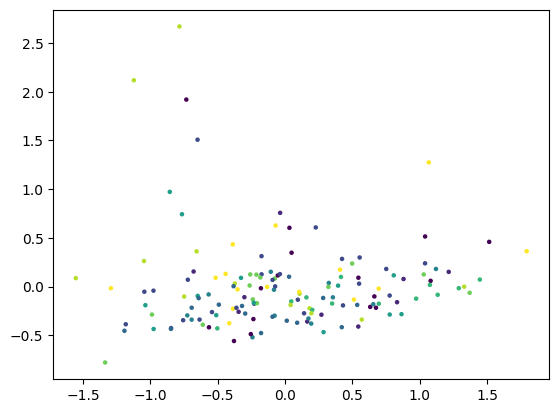

In [32]:
pca = PCA(n_components=16)
emb = pca.fit_transform(minmax_scale(graph_feat))
plt.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(true_labels), s=5)

In [33]:
clustering = SpectralClustering(
    n_clusters=10, 
    n_neighbors=6,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
)

pred_labels = clustering.fit_predict(emb)

print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}'''
)

homogeneity_score: 0.1550
completeness_score: 0.1623
v_measure_score: 0.1586
adjusted_rand_score: 0.0088
